# Importing Libraries

In [1]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

In [2]:
import os
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from tensorflow.keras.layers import Flatten, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy

## Variables that can be changed

In [3]:
CALLBACK = True # put "False" if you don't wanna use it
IMG_SIZE = 224 # image size for the model
EPOCHS = 50
BATCH_SIZE = 8
RESIZE_BACKGROUND = 500 # a random 224x224 crop will be used when training
CLASSES = ["Apple", "Banana"] # object classes
NUM_OBJ = len(CLASSES) # number of objects presented in training

# Visualising Data

**Defining paths to data and creating a list**

In [4]:
data_dir = './datasets/fruits'
apple_dir = os.path.join(data_dir, 'apple')
banana_dir = os.path.join(data_dir, 'banana')
background_dir = os.path.join(data_dir, 'background')

apple_list = os.listdir(apple_dir)
banana_list = os.listdir(banana_dir)
background_list = os.listdir(background_dir)

**Randomly selecting objects and background**

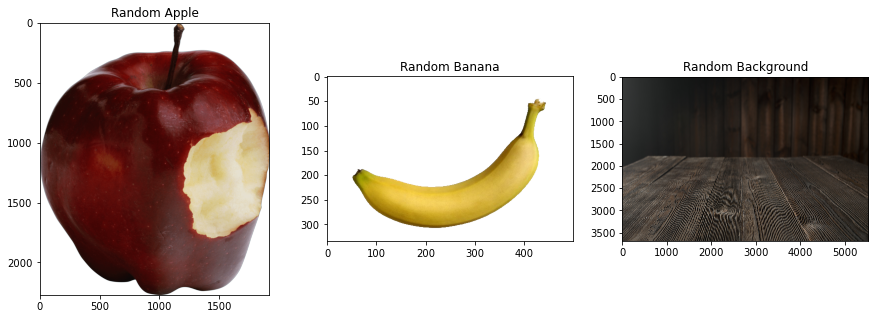

In [5]:
selected_apple = np.random.choice(apple_list)
selected_banana = np.random.choice(banana_list)
selected_background = np.random.choice(background_list)

plt.figure(figsize=(15, 5))

img = tf.io.read_file(os.path.join(apple_dir,selected_apple))
img = tf.image.decode_jpeg(img, channels=4)
img = tf.cast(img, tf.float32) / 255.0
plt.subplot(1, NUM_OBJ+1, 1)
plt.title('Random Apple')
plt.imshow(img)

img = tf.io.read_file(os.path.join(banana_dir,selected_banana))
img = tf.image.decode_jpeg(img, channels=4)
img = tf.cast(img, tf.float32) / 255.0
plt.subplot(1, NUM_OBJ+1, 2)
plt.title('Random Banana')
plt.imshow(img)

img = tf.io.read_file(os.path.join(background_dir,selected_background))
img = tf.image.decode_jpeg(img, channels=3)
img = tf.cast(img, tf.float32) / 255.0
plt.subplot(1, NUM_OBJ+1, 3)
plt.title('Random Background')
plt.imshow(img)

plt.show()

**Randomly creating an image of object with background**

Background image shape:  (3688, 5532, 3)
object size:  (3278, 3278, 4)


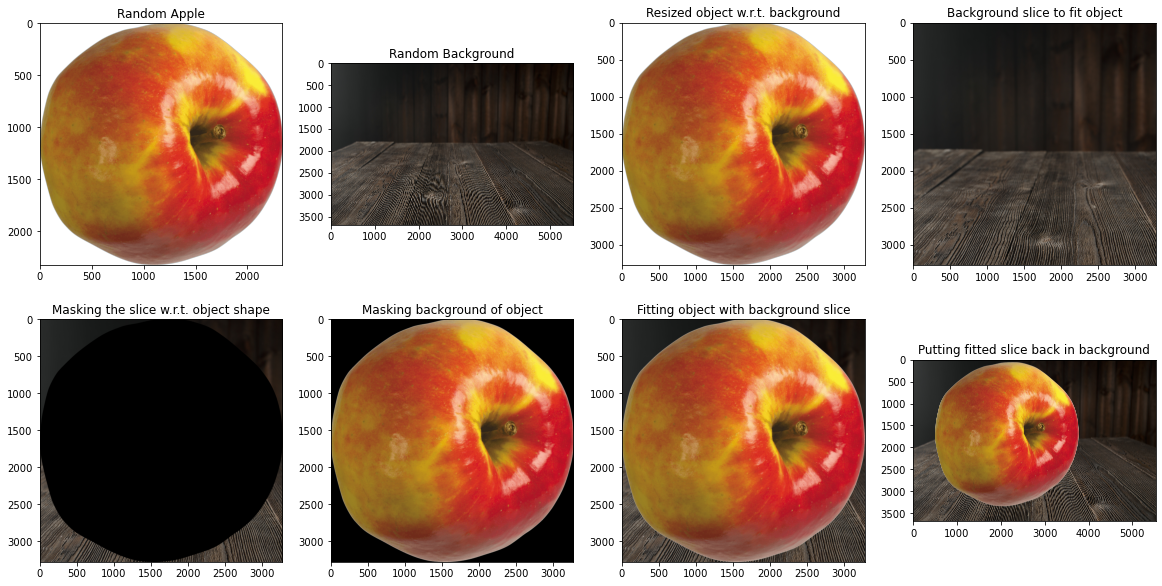

In [6]:
plt.figure(figsize=(20, 10))

choice = np.random.choice([os.path.join(apple_dir,np.random.choice(apple_list)),
                           os.path.join(banana_dir,np.random.choice(banana_list)),
                           None])
if choice:
    obj = tf.io.read_file(os.path.join(choice))
    obj = tf.image.decode_jpeg(obj, channels=4)
    obj = tf.cast(obj, tf.float32) / 255.0
    plt.subplot(2, 4, 1)
    plt.title('Random Apple')
    plt.imshow(obj)
    
    bg = tf.io.read_file(os.path.join(background_dir,np.random.choice(background_list)))
    bg = tf.image.decode_jpeg(bg, channels=3)
    bg = tf.cast(bg, tf.float32) / 255.0
    plt.subplot(2, 4, 2)
    plt.title('Random Background')
    plt.imshow(bg)
    print('Background image shape: ', bg.shape)
    
    max_size = min(bg.shape[0], bg.shape[1])
    min_size = int(max_size/5)
    obj_size = tf.random.uniform((), min_size , max_size, dtype=tf.int32)    
    
    resized_obj = tf.image.resize(obj, (obj_size, obj_size))
    print('object size: ', resized_obj.shape)
    plt.subplot(2, 4, 3)
    plt.title('Resized object w.r.t. background')
    plt.imshow(resized_obj)
    
    row0 = tf.random.uniform((), 0 , bg.shape[0] - obj_size, dtype=tf.int32)
    col0 = tf.random.uniform((), 0 , bg.shape[1] - obj_size, dtype=tf.int32)
    row1 = row0 + obj_size
    col1 = col0 + obj_size
    
    bg_slice1 = bg[row0:row1,col0:col1,:] # where we want to place `obj`
    plt.subplot(2, 4, 4)
    plt.title('Background slice to fit object')
    plt.imshow(bg_slice1)

    mask = (resized_obj[:,:,3] == 0) # find where the object is 0
    mask = tf.cast(mask, tf.float32)

    bg_slice2 = np.expand_dims(mask, -1) * bg_slice1 # (h,w,1) x (h,w,3)
    plt.subplot(2, 4, 5)
    plt.title('Masking the slice w.r.t. object shape')
    plt.imshow(bg_slice2)

    obj_slice = np.expand_dims(np.logical_not(mask), -1)*resized_obj[:,:,:3] # "add" the object to the slice
    plt.subplot(2, 4, 6)
    plt.title('Masking background of object')
    plt.imshow(obj_slice)

    bg_slice = bg_slice2 + obj_slice
    plt.subplot(2, 4, 7)
    plt.title('Fitting object with background slice')
    plt.imshow(bg_slice)

    bg = bg.numpy()
    bg[row0:row1,col0:col1,:] = bg_slice
    plt.subplot(2, 4, 8)
    plt.title('Putting fitted slice back in background')
    plt.imshow(bg)
    
else:
    bg = tf.io.read_file(os.path.join(background_dir,np.random.choice(background_list)))
    bg = tf.image.decode_jpeg(bg, channels=3)
    bg = tf.cast(bg, tf.float32) / 255.0
    bg = bg.numpy()
    plt.imshow(bg)
     
del bg

**Loading image in the list to speed up image generation for training**

<span style="color:red">**NOTE** :</span>
If the number of image is more than tens or hundred, don't make list because it will be stored in RAM which can cause error while executing

In [7]:
def load_image(path, channels = 3):
    bg = tf.io.read_file(path)
    bg = tf.image.decode_jpeg(bg, channels=channels)
    return tf.cast(bg, tf.float32) / 255.0

# Loading background JPG image in there respective list with 3 channel
backgrounds = [load_image(os.path.join(background_dir, i)) for i in background_list]

# Loading objects in there respective list with 4 channel because those are PNG images
apples = [load_image(os.path.join(apple_dir, i), 4) for i in apple_list]
bananas = [load_image(os.path.join(banana_dir, i), 4) for i in banana_list]

**Creating a fuunction to resize the background image and taking a random crop of size 224x224**

In [8]:
# @tf.function
def resize_crop_img(img):
    img = tf.image.resize(img, (RESIZE_BACKGROUND, RESIZE_BACKGROUND), preserve_aspect_ratio=True)
    return tf.image.random_crop(img, (IMG_SIZE, IMG_SIZE, 3))

len_apples = len(apples)
len_bananas = len(bananas)
len_backgrounds = len(backgrounds)

# Data Generation
The data is generated with background and object with output defined as coordinates_of_objects at [0:4], target_objects_presence[4:-1] and object_appeared[-1].

In [9]:
def data_generator(batch_size=BATCH_SIZE):
    # generate image and targets
    while True:
        # Each epoch will have 50 batches
        for _ in range(50):
            X = np.zeros((batch_size, IMG_SIZE, IMG_SIZE, 3), dtype=np.float32)
            Y = np.zeros((batch_size, 5+NUM_OBJ))
            for i in range(batch_size):

                random_bg = tf.random.uniform((), 0 , len_backgrounds, dtype=tf.int32)
                bg = backgrounds[random_bg]
                bg = resize_crop_img(bg)
                bg = bg.numpy()
                
                # == IF NUMBER OF OBJECTS IS CHANGED, THE CODE HERE NEEDED TO BE CHANGED
                c_index = np.random.choice(list(range(3)))
                if c_index:
                    Y[i, -1] = 1
                    if c_index == 1:
                        index = tf.random.uniform((), 0 , len_apples, dtype=tf.int32)
                        obj = apples[index]
                        Y[i,4] = 1
                    else:
                        index = tf.random.uniform((), 0 , len_bananas, dtype=tf.int32)
                        obj = bananas[index]
                        Y[i,-2] = 1
                # == CODE NEEDED TO BE CHANGED TILL HERE

                    max_size = IMG_SIZE
                    min_size = int(max_size/5)
                    obj_size = tf.random.uniform((), min_size , max_size, dtype=tf.int32)
                    resized_obj = tf.image.resize(obj, (obj_size, obj_size))

                    row0 = tf.random.uniform((), 0 , IMG_SIZE - obj_size, dtype=tf.int32)
                    col0 = tf.random.uniform((), 0 , IMG_SIZE - obj_size, dtype=tf.int32)
                    row1 = row0 + obj_size
                    col1 = col0 + obj_size

                    bg_slice = bg[row0:row1,col0:col1,:]
                    mask = (resized_obj[:,:,3] == 0)
                    mask = tf.cast(mask, tf.float32)

                    bg_slice = np.expand_dims(mask, -1) * bg_slice # (h,w,1) x (h,w,3)
                    obj_slice = np.expand_dims(np.logical_not(mask), -1)*resized_obj[:,:,:3]
                    bg_slice = bg_slice + obj_slice
                    bg[row0:row1,col0:col1,:] = bg_slice

                    # location
                    Y[i,0] = row0/bg.shape[0]
                    Y[i,1] = col0/bg.shape[1]
                    Y[i,2] = (row1 - row0)/bg.shape[0]
                    Y[i,3] = (col1 - col0)/bg.shape[1]

                X[i] = bg
            yield X, Y

Just checking if function **data_generator()** is running properly

In [10]:
xx = None
yy = None
for x, y in data_generator():
    xx, yy = x, y
    break

## Defining callback

In [11]:
if CALLBACK:
    
    class myCallback(tf.keras.callbacks.Callback):
        def __init__(self, target_loss = 0.3, patience = 3):
            super(myCallback, self).__init__()
            self.target_loss = target_loss
            self.curr_loss = np.inf
            self.best_loss = np.inf
            self.init_patience = patience
            self.patience = patience

        def on_epoch_end(self, epoch, logs={}):
            self.curr_loss = logs.get('loss')
            print(f'Loss after epoch: {self.curr_loss}')
            if(self.curr_loss < self.target_loss):
                print("\t\t\tDesired Loss achieved :)")
            if(self.curr_loss>self.best_loss):
                print("\t\t/!\\/!\\/!\\ Loss is not decreasing /!\\/!\\/!\\")
                self.patience -= 1
                if (self.patience == 0):
                        print('\n\t\t!!!!!!!!! Training has been stopped !!!!!!!!!')
                        self.model.stop_training = True 
            else:
                self.best_loss = self.curr_loss
                self.patience = self.init_patience

    callbacks = myCallback(patience = 6) # using callback with patience = 6

    checkpoint_filepath = 'my_model.h5'
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='loss',
        mode='min',
        save_best_only=True) # model will be saved when loss is least
    
    my_callback = [callbacks, model_checkpoint_callback]
    
else:
    
    my_callback = None

## Defining custom loss function

In [12]:
def custom_loss(y_true, y_pred):
    # target is a 7-tuple
    # (row, col, depth, width, class1, class2, object_appeared)

    bce = binary_crossentropy(y_true[:, :4], y_pred[:, :4]) # location
    cce = categorical_crossentropy(y_true[:, 4: -1], y_pred[:, 4: -1]) # object class
    bce2 = binary_crossentropy(y_true[:, -1], y_pred[:, -1]) # object appeared

    return bce * y_true[:, -1] + cce * y_true[:, -1] + bce2

# Defining VGG model with custom layers and running it

In [13]:
def make_model():
    vgg = tf.keras.applications.VGG16(
        input_shape=[IMG_SIZE, IMG_SIZE, 3],
        include_top=False,
        weights='imagenet')
    x = Flatten()(vgg.output)
    x1 = Dense(4, activation='sigmoid')(x) # location
    x2 = Dense(2, activation='softmax')(x) # object class
    x3 = Dense(1, activation='sigmoid')(x) # object appeared
    x = Concatenate()([x1, x2, x3])
    model = Model(vgg.input, x)
    model.compile(loss=custom_loss,
                  optimizer=Adam(lr=0.0001))
    return model

In [14]:
model = make_model()
history = model.fit(
    data_generator(),
    steps_per_epoch=50,
    epochs=50,
    verbose = 1,
    callbacks=my_callback
)

Epoch 1/50
50/50 [==============================] - 14s 187ms/step - loss: 1.0425
Loss after epoch: 0.8015660643577576
Epoch 2/50
50/50 [==============================] - 9s 185ms/step - loss: 0.3890
Loss after epoch: 0.37220242619514465
Epoch 3/50
50/50 [==============================] - 9s 189ms/step - loss: 0.3673
Loss after epoch: 0.35488978028297424
Epoch 4/50
50/50 [==============================] - 9s 190ms/step - loss: 0.3320
Loss after epoch: 0.33963581919670105
Epoch 5/50
50/50 [==============================] - 10s 199ms/step - loss: 0.3816
Loss after epoch: 0.36971649527549744
		/!\/!\/!\ Loss is not decreasing /!\/!\/!\
Epoch 6/50
50/50 [==============================] - 10s 191ms/step - loss: 0.3236
Loss after epoch: 0.31837567687034607
Epoch 7/50
50/50 [==============================] - 10s 194ms/step - loss: 0.3653
Loss after epoch: 0.3578042984008789
		/!\/!\/!\ Loss is not decreasing /!\/!\/!\
Epoch 8/50
50/50 [==============================] - 10s 196ms/step - loss: 

## Evaluating the model learning history

Evaluation parameters are:  ['loss']


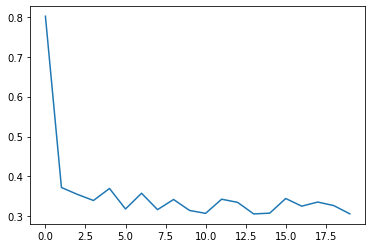

In [15]:
print('Evaluation parameters are: ', list(history.history.keys()))
for parameter_name, parameter in history.history.items():
    epochs = range(len(parameter))
    plt.plot(epochs, parameter, label=parameter_name)
plt.show()

# Predicting
For prediction, an image is first generated and then passed through the model

In [16]:
# Make predictions
def prediction_multiclass():
    random_bg = tf.random.uniform((), 0 , len_backgrounds, dtype=tf.int32)
    bg = backgrounds[random_bg]
    bg = resize_crop_img(bg)
    bg = bg.numpy()
    
    c_index = np.random.choice(range(3))
    choice = choices[c_index]
    if choice:
        obj = tf.io.read_file(os.path.join(choice))
        obj = tf.image.decode_jpeg(obj, channels=4)
        obj = tf.cast(obj, tf.float32) / 255.0
                    
        max_size = min(bg.shape[0], bg.shape[1])
        min_size = int(max_size/5)
        obj_size = tf.random.uniform((), min_size , max_size, dtype=tf.int32)
                    
        obj_max_index = tf.math.argmax((obj.shape[0], obj.shape[1]))
        resized_obj = tf.image.resize(obj, (obj_size, obj_size))
                    
        row0 = tf.random.uniform((), 0 , bg.shape[0] - obj_size, dtype=tf.int32)
        col0 = tf.random.uniform((), 0 , bg.shape[1] - obj_size, dtype=tf.int32)
        row1 = row0 + obj_size
        col1 = col0 + obj_size

        bg_slice1 = bg[row0:row1,col0:col1,:] # where we want to place `obj`
                    
        mask = (resized_obj[:,:,3] == 0) # find where the pokemon is 0
        mask = tf.cast(mask, tf.float32)
        bg_slice2 = np.expand_dims(mask, -1) * bg_slice1 # (h,w,1) x (h,w,3)
        obj_slice = np.expand_dims(np.logical_not(mask), -1)*resized_obj[:,:,:3]
        bg_slice = bg_slice2 + obj_slice
                    
        bg[row0:row1,col0:col1,:] = bg_slice
        
        actual_class = CLASSES[c_index]
        print("true:", int(row0), int(col0), int(row1), int(col1), actual_class)
    
  
    x = tf.image.resize(bg, (IMG_SIZE, IMG_SIZE))
    # Predict
    X = np.expand_dims(x, 0)
    p = model.predict(X)[0]

    # Plot
    fig, ax = plt.subplots(1)
    ax.imshow(x)
  
    # Draw the box
    if p[-1] > 0.5:
        row0 = int(p[0]*bg.shape[0])
        col0 = int(p[1]*bg.shape[1])
        row1 = int(row0 + p[2]*bg.shape[0])
        col1 = int(col0 + p[3]*bg.shape[1])
        class_pred_idx = np.argmax(p[4:6])
        class_pred = CLASSES[class_pred_idx]
        print("pred:", row0, col0, row1, col1, class_pred)
        rect = Rectangle(
            (p[1]*IMG_SIZE, p[0]*IMG_SIZE),
            p[3]*IMG_SIZE, p[2]*IMG_SIZE,linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
    else:
        print("pred: no object")
    plt.show()

true: 98 99 160 161 Apple
pred: 80 92 159 167 Apple


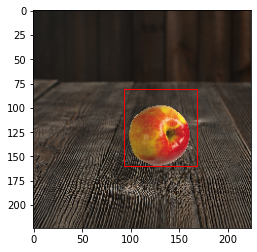

In [17]:
choices = [os.path.join(apple_dir,np.random.choice(apple_list)),
           os.path.join(banana_dir,np.random.choice(banana_list)),
           None]
prediction_multiclass()